In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import os
import pathlib
import string
import re
import pickle
from pickle import dump
import unicodedata
from unicodedata import normalize
import random

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
cd gdrive/MyDrive

/content/gdrive/MyDrive


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 18 23:16:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset preprocessing

### Europarl dataset

In [ ]:
# load doc into memory
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text
 
# split a loaded document into sentences
def to_sentences(doc):
	return doc.strip().split('\n')
 
# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	table = str.maketrans('', '', string.punctuation)
	for line in lines:

		line = normalize('NFD', line).encode('ascii', 'ignore')
		line = line.decode('UTF-8')

		line = line.split()

		line = [word.lower() for word in line]

		line = [word.translate(table) for word in line]

		line = [re_print.sub('', w) for w in line]

		line = [word for word in line if word.isalpha()]
		line = ' '.join(line)
		line = '<start> ' + line + ' <end>'
		# store as string
		cleaned.append(line)
	return cleaned
 
# save a list of clean sentences to file
def save_clean_sentences(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

def load_datasets(filename):
    return pickle.load(open(filename, 'rb'))

def produce_train_test(en, fr, ratio = 0.9, total_size = 5000):
    n_train = int(total_size * ratio)
    indexes = random.sample(range(total_size), n_train)
    trainX =  en[indexes]
    trainY = fr[indexes]

    testX = en[[i for i in range(total_size) if i not in indexes]]
    testY = fr[[i for i in range(total_size) if i not in indexes]]
    return trainX, trainY, testX, testY

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer(filters = '')
	tokenizer.fit_on_texts(lines)
	return tokenizer


# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	X = tokenizer.texts_to_sequences(lines)
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 

In [ ]:
# load English data
filename = 'europarl-v7.fr-en.en'
doc = load_doc(filename)
en_sentences = to_sentences(doc)
en_sentences = clean_lines(en_sentences)
 
# load French data
filename = 'europarl-v7.fr-en.fr'
doc = load_doc(filename)
fr_sentences = to_sentences(doc)
fr_sentences = clean_lines(fr_sentences)

In [ ]:
# save cleaned dataset
save_clean_sentences(en_sentences, 'english.pkl')
save_clean_sentences(fr_sentences, 'french.pkl')

Saved: english.pkl
Saved: french.pkl


In [ ]:
# load cleaned data to generate datasets
en_sentences = load_datasets('english.pkl')
fr_sentences = load_datasets('french.pkl')

In [ ]:
total_size = 5000
en = np.array(en_sentences[:total_size])
fr = np.array(fr_sentences[:total_size])

In [ ]:
trainX, trainY, testX, testY = produce_train_test(en, fr)

### manythings dataset

In [7]:
text_file = keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra-eng" / "fra.txt"
# text_file = "fra.txt"
text_file = "fra.txt"

In [10]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    # print(line.split("\t"))
    eng, fr, _ = line.split("\t")
    fr = "[start] " + fr + " [end]"
    text_pairs.append((eng, fr))
    if len(text_pairs) == 55000:
        break

In [12]:
for _ in range(5):
    print(random.choice(text_pairs))

('Tom led the attack.', "[start] Tom a dirigé l'offensive. [end]")
('No one had an answer.', "[start] Personne n'avait de réponse. [end]")
('They want more.', '[start] Ils en veulent davantage. [end]')
('Keep an eye on it.', '[start] Gardez un œil dessus. [end]')
('Replace it.', '[start] Remplacez-la. [end]')


In [13]:
random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

55000 total pairs
44000 training pairs
5500 validation pairs
5500 test pairs


In [15]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 50000
sequence_length = 50
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [18]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [19]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 50)
inputs["decoder_inputs"].shape: (64, 50)
targets.shape: (64, 50)


# Encoder class

In [20]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# Positional embedding

In [21]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Decoder Class

In [22]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Training

In [23]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [24]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)
# transformer.save('transformers_anki.h5')

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   12812800    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

# Evaluation

In [25]:
import matplotlib.pyplot as plt 
 
def plot_training(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    # val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label = 'training loss')
    # plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('training and validation loss')
    plt.legend()

    # Plot training and validation accuracy
    # plt.figure()
    # plt.plot(epochs, acc, 'bo', label = 'training accuracy')
    # plt.plot(epochs, val_acc, 'b', label = 'validation accuracy')
    # plt.title('training and validation accuracy')
    # plt.legend()
    # plt.show()

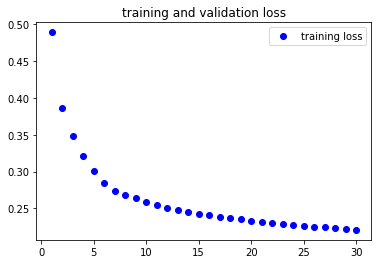

In [26]:
plot_training(history)

In [27]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)

Tom continued eating. [start] tom a continué à manger [end]
Do you smoke? [start] estce que vous êtes fumer [end]
I'll stop. [start] je vais marrêter [end]
Everybody dies. [start] tout le monde est en train de se mettre en le un monde le une [end]
Kids are cruel. [start] les enfants sont vous en enfants [end]
He is a detective. [start] il est vous en le le vous le le vous est [end]
The clock says two. [start] la note toutes les deux [end]
Take care of yourself. [start] prends attention [end]
Do you promise? [start] estce que vous êtes en mot [end]
It's not a classroom. [start] ce nest pas une part vous à bonnes tête [end]
You have to resign. [start] tu dois se fier [end]
He can't be young. [start] il ne peut pas être jeune [end]
Ask them. [start] tu te demande [end]
What day is it today? [start] quel jour cela estil ça aujourdhui [end]
That depends on you. [start] Ça a fait un point vous [end]
I can go next week. [start] je peux ten aller la semaine [end]
Don't threaten me. [start] ne 

### Bleu score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def code_to_text(sentence, tokenizer):
    result = ''
    for j in sentence:
        if j != 2 and j != 1:
            result += tokenizer.index_word[j] + ' '
        if j == 2:
            break
    return result

def evaluate_model(test_pairs):
    actual, predicted = [], []
    bleu = 0
    i = 0
    for eng, fr in test_pairs:
        
        # translate to target lang
        # print(eng)
        result = decode_sequence(eng)
        if i < 20:
            print('src=[%s], target=[%s], predicted=[%s]\n' % (eng, fr, result))
            i += 1
        actual.append([eng.split()])
        predicted.append(result.split()[:-1])

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.0, 1, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 1, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 0, 1)))

In [ ]:
evaluate_model(test_pairs)

src=[My neighbor is nice.], target=[Ma voisine est charmante.], predicted=[[start] les cheveux sont sympa                ]

src=[Sit down!], target=[Assieds-toi !], predicted=[[start] bien                   ]

src=[Tom is impressive.], target=[Tom est impressionnant.], predicted=[[start] est de la                 ]

src=[I study French.], target=[J'étudie le français.], predicted=[[start] le français                  ]

src=[The light is off.], target=[La lumière est éteinte.], predicted=[[start] le lumière                  ]

src=[I really love cats.], target=[J'adore vraiment les chats.], predicted=[[start] vraiment                   ]

src=[She was making tea.], target=[Elle était en train de faire du thé.], predicted=[[start] bien du thé                 ]

src=[This egg is fresh.], target=[C'est un œuf frais.], predicted=[[start] les un                  ]

src=[I'm not dangerous.], target=[Je ne suis pas dangereux.], predicted=[[start] pas venir                  ]

src=[Try to rest

KeyboardInterrupt: ignored

In [ ]:
decode_sequence(test_pairs[0][0])

'[start] les cheveux sont sympa                '

In [ ]:
testY.shape

(5000, 57)